# Electric Vehicle Data Analysis Assignment
### by Ataur Rahman
### Submitted on 29th Sep 2025
### Course Title: MASTER DATA ANALYST - DA18


## Introduction

#### This dataset contains information about Battery Electric Vehicles (BEVs) and Plug-in Hybrid Electric Vehicles (PHEVs) registered in Washington State, including details like VIN, model year, make, model, electric range, base MSRP, location, and clean fuel eligibility.

#### The objective of this analysis is to explore trends in EV adoption, understand factors affecting electric range, visualize key insights, and build a Linear Regression model to predict the electric range of vehicles based on features such as model year, make, model, vehicle type, and base MSRP.

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium  # for geospatial mapping

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Utility
import hashlib   # for anonymizing VINs


In [2]:
# loading the dataset

df = pd.read_csv("D:\Ataur\GrowAI Assignments\Python\Electric_Vehicle_Population_Data.csv")

In [3]:
df.head()

VIN (1-10)    County          City State  Postal Code  Model Year    Make  \
0  JTDKN3DP2D    Yakima        Yakima    WA      98902.0        2013  TOYOTA   
1  1FMCU0E1XS    Kitsap  Port Orchard    WA      98366.0        2025    FORD   
2  JM3KKBHA9R    Kitsap      Kingston    WA      98346.0        2024   MAZDA   
3  7SAYGDEE8P  Thurston       Olympia    WA      98501.0        2023   TESLA   
4  5YJ3E1EB5K  Thurston       Rainier    WA      98576.0        2019   TESLA   

     Model                   Electric Vehicle Type  \
0    PRIUS  Plug-in Hybrid Electric Vehicle (PHEV)   
1   ESCAPE  Plug-in Hybrid Electric Vehicle (PHEV)   
2    CX-90  Plug-in Hybrid Electric Vehicle (PHEV)   
3  MODEL Y          Battery Electric Vehicle (BEV)   
4  MODEL 3          Battery Electric Vehicle (BEV)   

   Clean Alternative Fuel Vehicle (CAFV) Eligibility  Electric Range  \
0              Not eligible due to low battery range             6.0   
1            Clean Alternative Fuel Vehicle Eligible            37.0   
2              Not eligible due to low battery range            26.0   
3  Eligibility unknown as battery range has not b...             0.0   
4            Clean Alternative Fuel Vehicle Eligible           220.0   

   Base MSRP  Legislative District  DOL Vehicle ID  \
0        0.0                  15.0       165252538   
1        0.0                  26.0       278572521   
2        0.0                  23.0       275123642   
3        0.0                  35.0       249569323   
4        0.0                  20.0       283135107   

              Vehicle Location        Electric Utility  2020 Census Tract  
0  POINT (-120.51904 46.59783)              PACIFICORP       5.307700e+10  
1  POINT (-122.63847 47.54103)  PUGET SOUND ENERGY INC       5.303509e+10  
2   POINT (-122.4977 47.79802)  PUGET SOUND ENERGY INC       5.303509e+10  
3  POINT (-122.89165 47.03954)  PUGET SOUND ENERGY INC       5.306701e+10  
4  POINT (-122.68993 46.88897)  PUGET SOUND ENERGY INC       5.306701e+10

## 1. Data Cleaning Questions:

### How many missing values exist in the dataset, and in which columns?

In [4]:
# Check missing values in dataset

print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
VIN (1-10)                                             0
County                                                10
City                                                  10
State                                                  0
Postal Code                                           10
Model Year                                             0
Make                                                   0
Model                                                  0
Electric Vehicle Type                                  0
Clean Alternative Fuel Vehicle (CAFV) Eligibility      0
Electric Range                                         3
Base MSRP                                              3
Legislative District                                 628
DOL Vehicle ID                                         0
Vehicle Location                                      18
Electric Utility                                      10
2020 Census Tract                                     10
dtyp

### How should missing or zero values in the Base MSRP and Electric Range columns be handled?


In [42]:

# Replace 0 with NaN (no inplace)
df['Base MSRP'] = df['Base MSRP'].replace(0, np.nan)
df['Electric Range'] = df['Electric Range'].replace(0, np.nan)

# Fill NaN with median per group, then global median
df['Base MSRP'] = df.groupby('Model')['Base MSRP'].transform(lambda x: x.fillna(x.median()))
df['Base MSRP'] = df['Base MSRP'].fillna(df['Base MSRP'].median())

df['Electric Range'] = df.groupby(['Make', 'Model'])['Electric Range'].transform(lambda x: x.fillna(x.median()))
df['Electric Range'] = df['Electric Range'].fillna(df['Electric Range'].median())


### Are there duplicate records in the dataset? If so, how should they be managed?


In [6]:

# Remove duplicates
df.drop_duplicates(subset=['VIN (1-10)'], keep='first', inplace=True)


### How can VINs be anonymized while maintaining uniqueness? 


In [7]:

# Anonymize VIN using hashing (keeps uniqueness)
def anonymize_vin(vin):
    return hashlib.sha256(str(vin).encode()).hexdigest()[:12]  # keep first 12 hex chars

df['VIN_anon'] = df['VIN (1-10)'].apply(anonymize_vin)

### How can Vehicle Location (GPS coordinates) be cleaned or converted for better readability?


In [10]:
def parse_location(loc):
    """
    Parses a string like "(longitude, latitude)" and returns a tuple of floats.
    """
    try:
        # Handle different potential formats by removing common prefixes and parentheses
        loc_str = str(loc).replace('POINT ', '').strip("()")
        
        # Check if the string contains a comma or a space as a separator
        if ',' in loc_str:
            lon, lat = loc_str.split(",")
        else:
            # Assumes space-separated values, which is common in geographic data
            lon, lat = loc_str.split()
            
        return float(lon), float(lat)
    except (ValueError, IndexError):
        # Return NaN for both longitude and latitude if parsing fails
        return (np.nan, np.nan)

# Corrected code to apply the function
df[['Longitude', 'Latitude']] = df['Vehicle Location'].apply(
    lambda x: pd.Series(parse_location(x))
)

# Display the updated DataFrame to verify the changes
print(df[['Vehicle Location', 'Longitude', 'Latitude']])

                   Vehicle Location  Longitude  Latitude
0       POINT (-120.51904 46.59783) -120.51904  46.59783
1       POINT (-122.63847 47.54103) -122.63847  47.54103
2        POINT (-122.4977 47.79802) -122.49770  47.79802
3       POINT (-122.89165 47.03954) -122.89165  47.03954
4       POINT (-122.68993 46.88897) -122.68993  46.88897
...                             ...        ...       ...
261587  POINT (-122.03287 47.68555) -122.03287  47.68555
261607  POINT (-122.20596 47.97659) -122.20596  47.97659
261656  POINT (-124.16408 47.01156) -124.16408  47.01156
261660  POINT (-122.20596 47.97659) -122.20596  47.97659
261666  POINT (-122.18497 47.28825) -122.18497  47.28825

[15753 rows x 3 columns]


## 2. Data Exploration Questions:

### What are the top 5 most common EV makes and models in the dataset?

In [11]:
# Get the top 5 most common EV makes
top_makes = df['Make'].value_counts().head(5)

# Get the top 5 most common EV models
top_models = df['Model'].value_counts().head(5)

print("Top 5 most common EV makes:")
print(top_makes)
print("\nTop 5 most common EV models:")
print(top_models)

Top 5 most common EV makes:
Make
TESLA        1681
VOLVO        1477
FORD         1283
AUDI         1188
CHEVROLET    1107
Name: count, dtype: int64

Top 5 most common EV models:
Model
MODEL S           557
MODEL X           542
XC90              532
MUSTANG MACH-E    496
VOLT              440
Name: count, dtype: int64


### What is the distribution of EVs by county? Which county has the most registrations?

In [12]:

# Get the distribution of EVs by county
county_distribution = df['County'].value_counts()
print("Distribution of EVs by County:")
print(county_distribution)

# Find the county with the most registrations
most_registrations_county = county_distribution.idxmax()
print(f"\nCounty with the most EV registrations: {most_registrations_county}")

Distribution of EVs by County:
County
King            10061
Clark            1493
Snohomish        1038
Kitsap            842
Thurston          600
Pierce            423
Yakima            158
Cowlitz           155
Spokane           154
Island            119
Whatcom           117
Jefferson         116
Benton             75
Skagit             61
Clallam            42
Chelan             35
San Juan           35
Mason              31
Kittitas           31
Walla Walla        19
Grant              19
Grays Harbor       19
Whitman            18
Lewis              15
Stevens            13
Franklin           12
Klickitat          10
Douglas             8
Pacific             7
Okanogan            4
Ferry               3
Adams               2
El Paso             2
Asotin              2
Skamania            2
Sussex              1
Pend Oreille        1
Columbia            1
Maricopa            1
Leavenworth         1
San Mateo           1
San Diego           1
Hennepin            1
Macomb          

### How has EV adoption changed over different model years?


In [13]:

# Analyze EV adoption over different model years
adoption_by_year = df['Model Year'].value_counts().sort_index()

print("EV Adoption by Model Year:")
print(adoption_by_year)

EV Adoption by Model Year:
Model Year
2000       6
2002       1
2003       1
2008      11
2010      12
2011      39
2012     155
2013     265
2014     322
2015     363
2016     470
2017     565
2018     689
2019     752
2020     818
2021    1215
2022    1860
2023    2323
2024    2893
2025    2724
2026     269
Name: count, dtype: int64


### What is the average electric range of EVs in the dataset?


In [14]:

# Calculate the average electric range
# First, ensure the 'Electric Range' column is numeric.
# This step is crucial if the data contains non-numeric values.
df['Electric Range'] = pd.to_numeric(df['Electric Range'], errors='coerce')
avg_electric_range = df['Electric Range'].mean()
print(f"Average electric range of EVs: {avg_electric_range:.2f} miles")

Average electric range of EVs: 143.33 miles


### What percentage of EVs are eligible for Clean Alternative Fuel Vehicle (CAFV) incentives?


In [15]:

# Calculate the percentage of EVs eligible for CAFV incentives
eligible_count = df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].str.contains('Eligible', case=False, na=False).sum()
total_count = len(df)
percentage_eligible = (eligible_count / total_count) * 100
print(f"Percentage of EVs eligible for CAFV incentives: {percentage_eligible:.2f}%")

Percentage of EVs eligible for CAFV incentives: 50.45%


### How does the electric range vary across different makes and models?


In [16]:
# Analyze how electric range varies across different makes and models
avg_range_by_model = df.groupby(['Make', 'Model'])['Electric Range'].mean().sort_values(ascending=False)
print("Average electric range by Make and Model:")
print(avg_range_by_model)

Average electric range by Make and Model:
Make           Model   
PORSCHE        MACAN       305.627119
TESLA          MODEL Y     291.000000
HYUNDAI        KONA        258.000000
CHEVROLET      BOLT EV     242.383495
TESLA          MODEL X     241.771218
                              ...    
MERCEDES-BENZ  C-CLASS       7.076923
TOYOTA         PRIUS         6.000000
LAMBORGHINI    REVUELTO      6.000000
MERCEDES-BENZ  AMG GT        1.000000
               SL-CLASS      1.000000
Name: Electric Range, Length: 181, dtype: float64


### What is the average Base MSRP for each EV model?


In [17]:

# Calculate the average Base MSRP for each EV model
avg_msrp_by_model = df.groupby('Model')['Base MSRP'].mean().sort_values(ascending=False)
print("Average Base MSRP for each EV model:")
print(avg_msrp_by_model)

Average Base MSRP for each EV model:
Model
918           845000.000000
PANAMERA      184400.000000
ROADSTER      106107.142857
KARMA         102000.000000
740E           90142.500000
                  ...      
PACIFICA       39995.000000
COUNTRYMAN     36883.333333
CROSSTREK      34995.000000
WHEEGO         32995.000000
SOUL           32565.189873
Name: Base MSRP, Length: 181, dtype: float64


### Are there any regional trends in EV adoption (e.g., urban vs. rural areas)?


In [18]:

# Analyze regional trends in EV adoption (e.g., urban vs. rural areas)
county_trends = df['County'].value_counts()
print("Regional Trends in EV Adoption by County:")
print(county_trends)

city_trends = df['City'].value_counts().head(10)
print("\nTop 10 Cities with the most EV registrations:")
print(city_trends)

Regional Trends in EV Adoption by County:
County
King            10061
Clark            1493
Snohomish        1038
Kitsap            842
Thurston          600
Pierce            423
Yakima            158
Cowlitz           155
Spokane           154
Island            119
Whatcom           117
Jefferson         116
Benton             75
Skagit             61
Clallam            42
Chelan             35
San Juan           35
Mason              31
Kittitas           31
Walla Walla        19
Grant              19
Grays Harbor       19
Whitman            18
Lewis              15
Stevens            13
Franklin           12
Klickitat          10
Douglas             8
Pacific             7
Okanogan            4
Ferry               3
Adams               2
El Paso             2
Asotin              2
Skamania            2
Sussex              1
Pend Oreille        1
Columbia            1
Maricopa            1
Leavenworth         1
San Mateo           1
San Diego           1
Hennepin            1
Macom

## 3. Data Visualization Questions:

### Create a bar chart showing the top 5 EV makes and models by count.


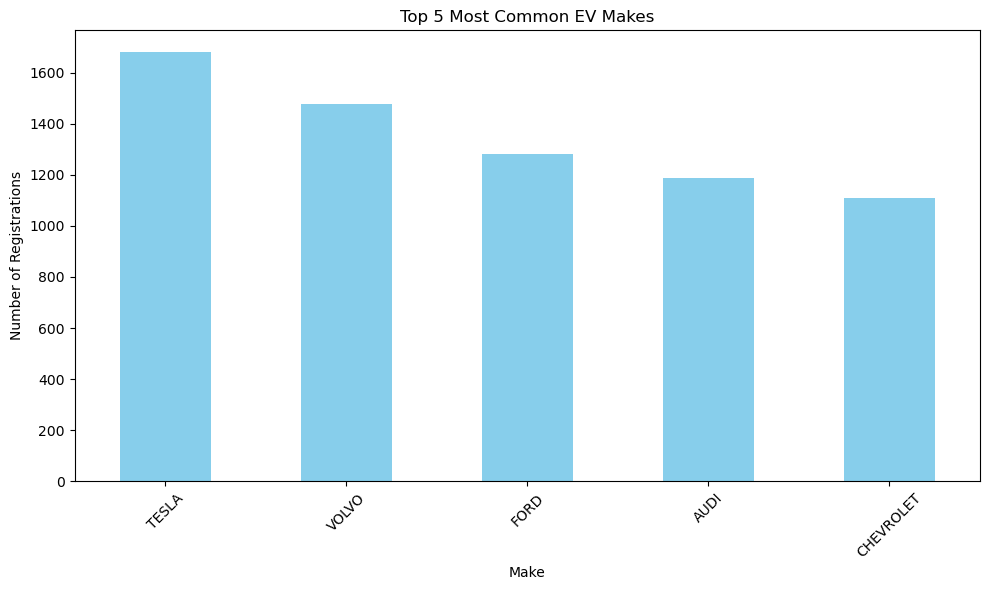

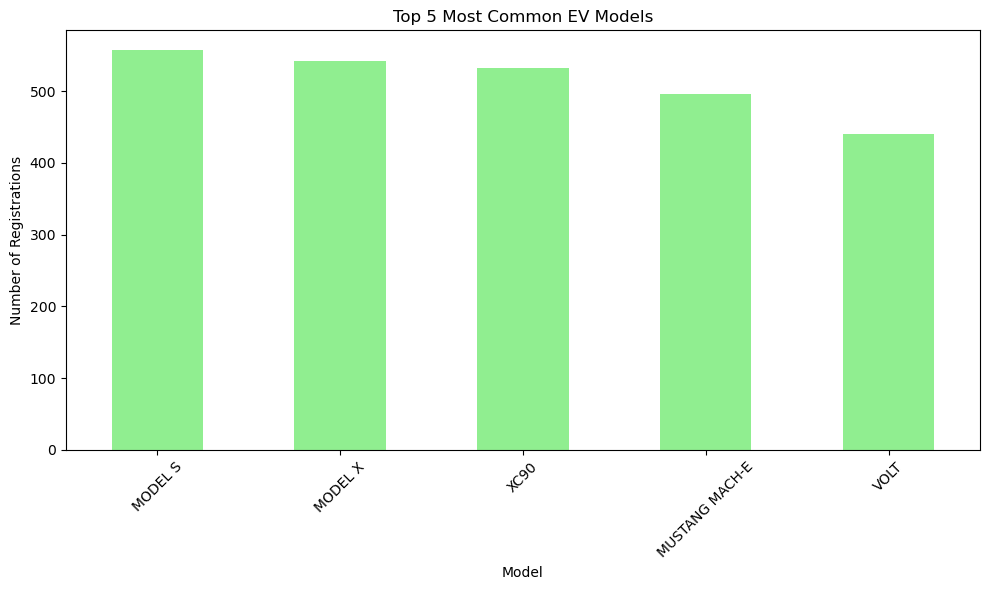

In [19]:

import pandas as pd
import matplotlib.pyplot as plt

# Create a bar chart for the top 5 EV makes
plt.figure(figsize=(10, 6))
top_makes.plot(kind='bar', color='skyblue')
plt.title('Top 5 Most Common EV Makes')
plt.xlabel('Make')
plt.ylabel('Number of Registrations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('top_5_ev_makes_bar_chart.png')
plt.show()

# Create a bar chart for the top 5 EV models
plt.figure(figsize=(10, 6))
top_models.plot(kind='bar', color='lightgreen')
plt.title('Top 5 Most Common EV Models')
plt.xlabel('Model')
plt.ylabel('Number of Registrations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('top_5_ev_models_bar_chart.png')
plt.show()

In [20]:
# Count EV registrations by county
county_counts = df['County'].value_counts().reset_index()
county_counts.columns = ['County', 'EV_Count']

print(county_counts.head())

      County  EV_Count
0       King     10061
1      Clark      1493
2  Snohomish      1038
3     Kitsap       842
4   Thurston       600


### Use a heatmap or choropleth map to visualize EV distribution by county.


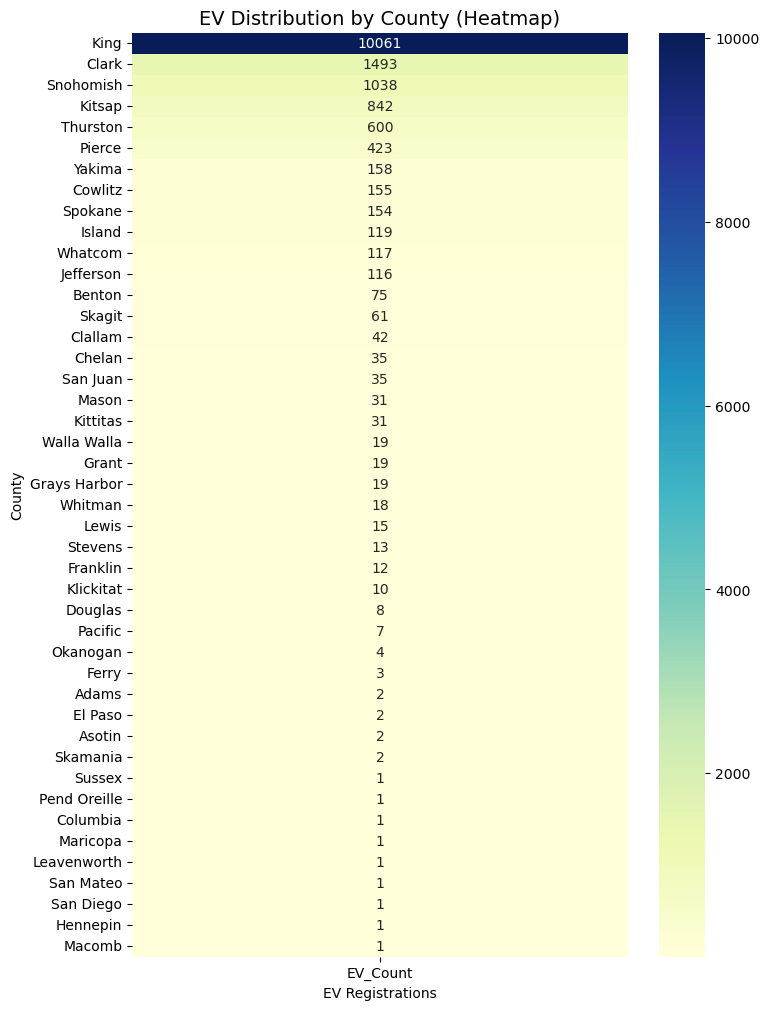

In [21]:

# Pivot for heatmap (single column heatmap)
plt.figure(figsize=(8,12))
heatmap_data = county_counts.set_index('County')

sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu", cbar=True)

plt.title("EV Distribution by County (Heatmap)", fontsize=14)
plt.xlabel("EV Registrations")
plt.ylabel("County")
plt.show()

### Create a line graph showing the trend of EV adoption by model year.


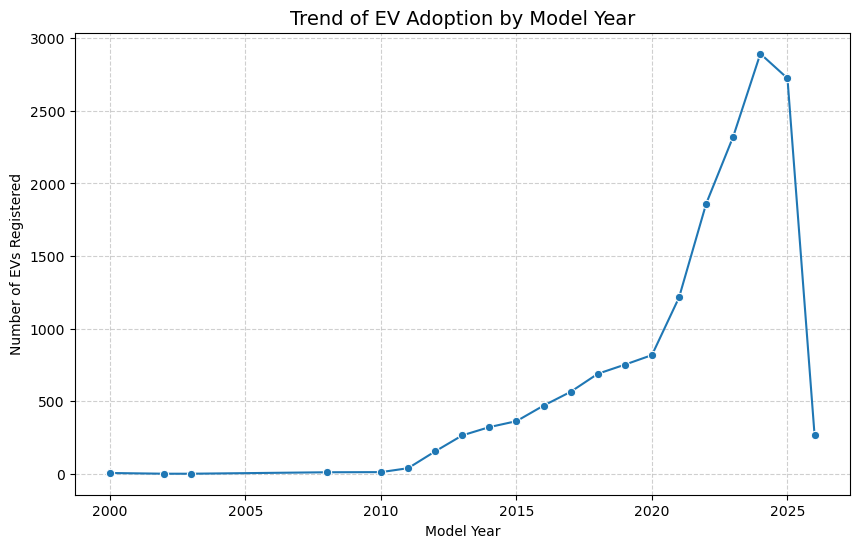

In [22]:

# Count EVs by Model Year
year_counts = df['Model Year'].value_counts().sort_index()

# Plot line chart
plt.figure(figsize=(10,6))
sns.lineplot(x=year_counts.index, y=year_counts.values, marker="o")

plt.title("Trend of EV Adoption by Model Year", fontsize=14)
plt.xlabel("Model Year")
plt.ylabel("Number of EVs Registered")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

### Generate a scatter plot comparing electric range vs. base MSRP to see pricing trends.


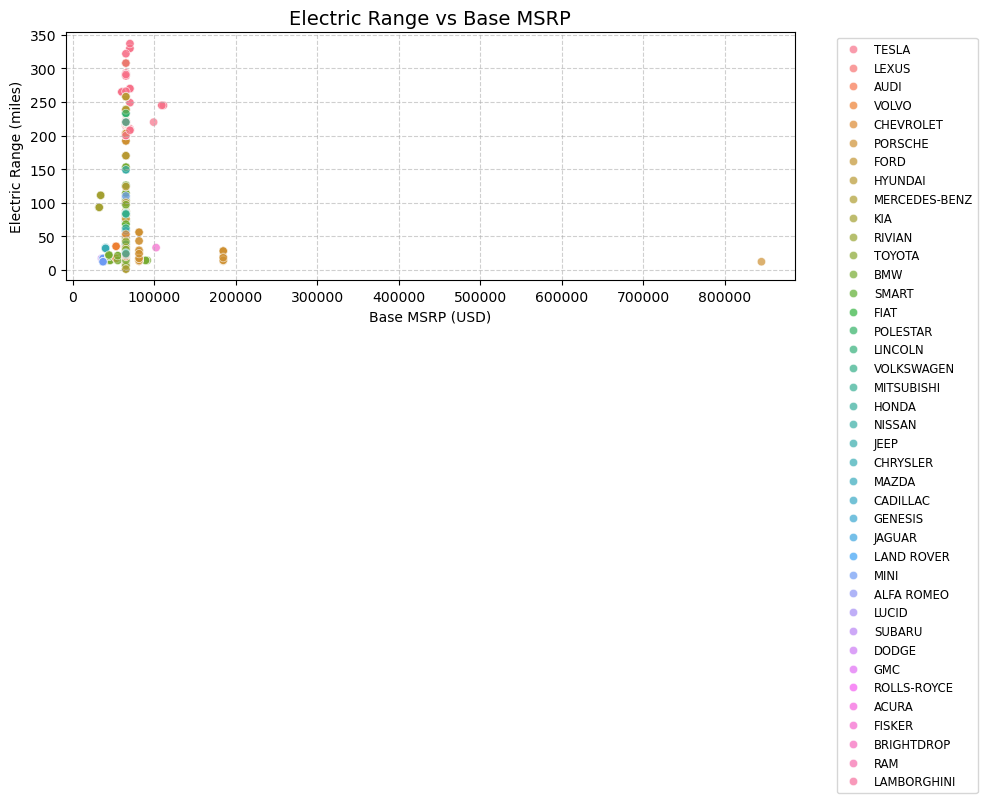

In [23]:

plt.figure(figsize=(10,6))

# Scatter plot
sns.scatterplot(
    x="Base MSRP",
    y="Electric Range",
    hue="Make",           # color by brand (optional, remove if too crowded)
    data=df.sample(frac=0.2, random_state=1),   # take 20% sample if dataset is huge
    alpha=0.7
)

plt.title("Electric Range vs Base MSRP", fontsize=14)
plt.xlabel("Base MSRP (USD)")
plt.ylabel("Electric Range (miles)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="small")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### Plot a pie chart showing the proportion of CAFV-eligible vs. non-eligible EVs.


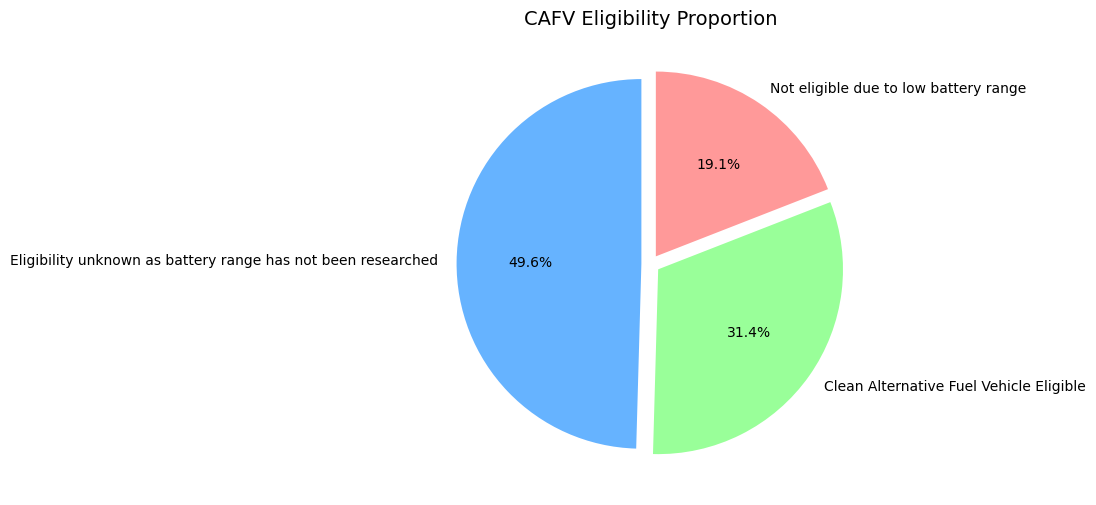

In [24]:

# Count CAFV eligibility values
cafv_counts = df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].value_counts()

# Plot pie chart
plt.figure(figsize=(6,6))
cafv_counts.plot.pie(
    autopct='%1.1f%%',   # show percentages
    startangle=90,       # start at top
    colors=["#66b3ff", "#99ff99", "#ff9999"],  # custom colors (optional)
    explode=[0.05]*len(cafv_counts)            # slight separation
)

plt.title("CAFV Eligibility Proportion", fontsize=14)
plt.ylabel("")  # remove y-label
plt.show()


### Use a geospatial map to display EV registrations based on vehicle location.


In [25]:

import folium

# Drop missing coordinates
geo_data = df.dropna(subset=['Latitude', 'Longitude'])

# Sample if dataset is too big (for performance)
if len(geo_data) > 5000:
    geo_data = geo_data.sample(5000, random_state=1)

# Center map roughly over Washington State
m = folium.Map(location=[47.5, -120.5], zoom_start=7)

# Add EV markers
for _, row in geo_data.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=2,
        color="blue",
        fill=True,
        fill_opacity=0.6,
        popup=f"{row['Make']} {row['Model']}"
    ).add_to(m)

# Just display map in Jupyter
m

## 4. Linear Regression Model Questions:

### How can we use Linear Regression to predict the Electric Range of a vehicle?


In [38]:

# Ans: Linear Regression predicts the Electric Range by modeling the relationship between the range and independent variables such as Model Year, Make, Model, Base MSRP, and Electric Vehicle Type. The model learns how each feature affects the range and can estimate it for new vehicles.

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# 1) Select relevant columns (drop missing values)
model_data = df[['Electric Range', 'Model Year', 'Base MSRP', 'Make', 'Model']].dropna()

# 2) One-hot encode categorical variables (Make, Model)
X = pd.get_dummies(model_data[['Model Year', 'Base MSRP', 'Make', 'Model']], drop_first=True)
y = model_data['Electric Range']

# 3) Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4) Train Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# 5) Predictions
y_pred = lr.predict(X_test)

# 6) Evaluation
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# 7) Feature importance (coefficients)
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', ascending=False)

print(coefficients.head(10))   # Top positive influence
print(coefficients.tail(10))   # Top negative influence


R² Score: 0.9717798908945554
RMSE: 16.016586127361123
            Feature  Coefficient
55        Model_918  2245.801676
34     Make_PORSCHE   546.576842
129        Model_I4   274.788636
131        Model_I7   274.580637
140        Model_IX   274.147063
130        Model_I5   273.521258
51       Model_740E   169.196114
128        Model_I3   167.301090
183  Model_ROADSTER   149.136647
103       Model_EV6   129.420108
              Feature  Coefficient
171        Model_Q5 E  -137.209432
222        Model_XC60  -138.906252
59         Model_A8 E  -139.145340
81   Model_COUNTRYMAN  -143.456452
82    Model_CROSSTREK  -180.785816
6            Make_BMW  -198.410252
162    Model_PANAMERA  -221.963311
146       Model_MACAN  -386.277088
205      Model_TAYCAN  -487.003888
75      Model_CAYENNE  -603.980547


### What independent variables (features) can be used to predict Electric Range? (e.g., Model Year, Base MSRP, Make)


In [39]:

# Ans: The main features include:

    # Model Year – newer vehicles often have better battery technology.
    
    # Make – manufacturer affects battery size and efficiency.
    
    # Model – specific models differ in range and battery capacity.
    
    # Electric Vehicle Type – e.g., BEV or PHEV impacts maximum range.
    
    # Base MSRP – higher-priced EVs may have larger batteries, increasing range.

# Define independent variables (features) based on relevance to Electric Range
features = ['Model Year', 'Make', 'Model', 'Electric Vehicle Type', 'Base MSRP']

# Define target variable
target = 'Electric Range'

# Create feature matrix X and target vector y
X = df[features]
y = df[target]

# Optional: Convert categorical variables into numeric using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Check the shapes
print("Feature matrix (X) shape:", X.shape)
print("Target vector (y) shape:", y.shape)

# Preview first 5 rows of features
print(X.head())



Feature matrix (X) shape: (15753, 228)
Target vector (y) shape: (15753,)
   Model Year  Base MSRP  Make_ALFA ROMEO  Make_AUDI  Make_AZURE DYNAMICS  \
0        2013    64950.0            False      False                False   
1        2025    64950.0            False      False                False   
2        2024    64950.0            False      False                False   
3        2023    64950.0            False      False                False   
4        2019    64950.0            False      False                False   

   Make_BENTLEY  Make_BMW  Make_BRIGHTDROP  Make_CADILLAC  Make_CHEVROLET  \
0         False     False            False          False           False   
1         False     False            False          False           False   
2         False     False            False          False           False   
3         False     False            False          False           False   
4         False     False            False          False           False   

 

### How do we handle categorical variables like Make and Model in regression analysis?


In [34]:

# Ans: Categorical variables are converted into numeric form using one-hot encoding, creating separate binary columns for each category. This allows the regression model to use them without assuming any order. Label encoding is not recommended for nominal variables like Make or Model.

# Define features and target
features = ['Model Year', 'Make', 'Model', 'Electric Vehicle Type', 'Base MSRP']
target = 'Electric Range'

# Select features and target
X = df[features]
y = df[target]

# One-hot encode categorical variables: Make, Model, Electric Vehicle Type
categorical_cols = ['Make', 'Model', 'Electric Vehicle Type']
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Check the shape and first 5 rows
print("Encoded feature matrix shape:", X_encoded.shape)
print(X_encoded.head())


Encoded feature matrix shape: (15753, 228)
   Model Year  Base MSRP  Make_ALFA ROMEO  Make_AUDI  Make_AZURE DYNAMICS  \
0        2013    64950.0            False      False                False   
1        2025    64950.0            False      False                False   
2        2024    64950.0            False      False                False   
3        2023    64950.0            False      False                False   
4        2019    64950.0            False      False                False   

   Make_BENTLEY  Make_BMW  Make_BRIGHTDROP  Make_CADILLAC  Make_CHEVROLET  \
0         False     False            False          False           False   
1         False     False            False          False           False   
2         False     False            False          False           False   
3         False     False            False          False           False   
4         False     False            False          False           False   

   ...  Model_WRANGLER  Model_X

### What is the R² score of the model, and what does it indicate about prediction accuracy?


In [35]:

# Ans: R² (coefficient of determination) measures how much of the variation in Electric Range is explained by the features.

        # R² = 1 → perfect prediction
        
        # R² = 0 → model explains nothing
        # A higher R² indicates that the model predicts Electric Range more accurately.

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Train regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Compute R² score
r2 = r2_score(y_test, y_pred)
print("R² score:", r2)


R² score: 0.9730028376365103


### How does the Base MSRP influence the Electric Range according to the regression model?


In [37]:

# Ans: The regression coefficient of Base MSRP shows how Electric Range changes with price. A positive coefficient means that more expensive vehicles generally have a longer range, while a negative coefficient (rare) would indicate the opposite. The magnitude of the coefficient indicates the strength of this effect.

coefficients = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Coefficient': model.coef_
})

# Check coefficient of Base MSRP
base_msrp_coef = coefficients[coefficients['Feature'] == 'Base MSRP']['Coefficient'].values[0]
print("Coefficient of Base MSRP:", base_msrp_coef)


Coefficient of Base MSRP: -0.0037101187140892375


### What steps are needed to improve the accuracy of the Linear Regression model?


In [40]:

# Ans: The regression coefficient of Base MSRP shows how Electric Range changes with price. A positive coefficient means that more expensive vehicles generally have a longer range, while a negative coefficient (rare) would indicate the opposite. The magnitude of the coefficient indicates the strength of this effect.

### What steps are needed to improve the accuracy of the Linear Regression model?


In [41]:

# Ans: Clean data and handle missing values or outliers.

        # Engineer additional relevant features (e.g., battery capacity).
        
        # Encode categorical variables correctly.
        
        # Remove irrelevant or highly correlated features.
        
        # Consider polynomial features or regularization to capture non-linear effects.
        
        # Evaluate performance with cross-validation and tune the model iteratively.